In [221]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d

# Ca IR: 8498 Å, 8542 Å and 8662 Å

class Spectrum(object):
    def __init__(self, wavelength, flux, min_wavelength=0.6, max_wavelength=5.3):
        condition = ((wavelength > min_wavelength) & 
                     (wavelength < max_wavelength) & 
                     ~np.isnan(flux))
        self.wavelength = wavelength[condition]
        self.flux = flux[condition]/np.nanmax(flux[condition])
        
    @classmethod
    def from_phoenix(cls, path):
        m = fits.getdata(path)
        return cls(m['Wavelength'], m['Flux'])

    @classmethod
    def from_irtf(cls, path):
        f = fits.getdata(path)
        return cls(f[0, :], f[1, :])

    def convolved(self, new_res):
        return Spectrum(self.wavelength, gaussian_filter1d(self.flux, new_res))

irtf1 = Spectrum.from_irtf("../libra/data/irtf/M8V_Gl752B.fits")
irtf2 = Spectrum.from_irtf("../libra/data/irtf/M8V_LP412-31.fits")

model = Spectrum.from_phoenix('../libra/data/phoenix/lte026.0-4.5-0.0a+0.0.BT-Settl.spec.fits')

(array([ 1.        ,  0.05113484]), 12436.265278671079, {'grad': array([     0.        ,  62126.39218575]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'nit': 4, 'funcalls': 165})


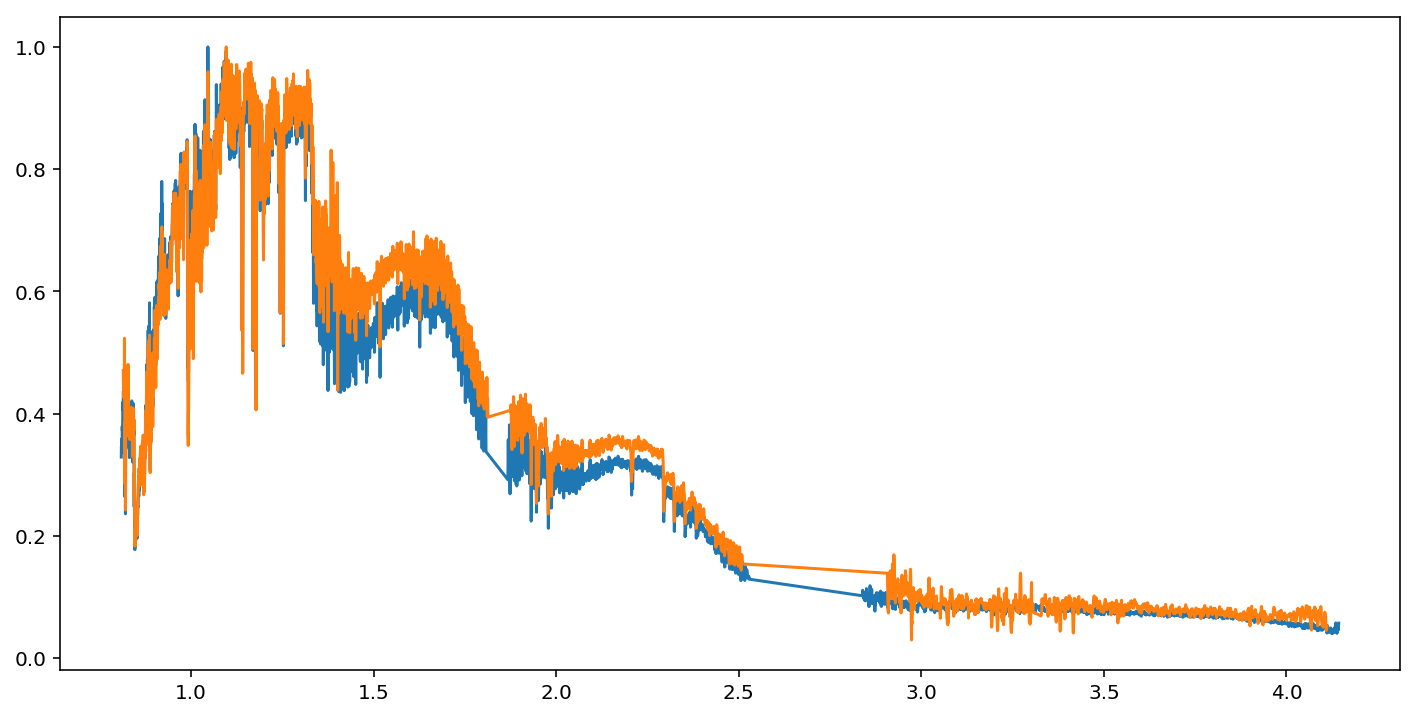

In [228]:
plt.figure(figsize=(12, 6))
plt.plot(irtf1.wavelength, irtf1.flux)
plt.plot(irtf2.wavelength, irtf2.flux)


def flux_model(p, modelspectrum):
    return p[0] * modelspectrum.flux + p[1] 

def chi2(p, modelspectrum, templatespectrum):
    interp_template = np.interp(modelspectrum.wavelength, templatespectrum.wavelength, 
                                templatespectrum.flux)
    return np.sum((flux_model(p, modelspectrum) - interp_template)**2)

from scipy.optimize import fmin_l_bfgs_b

bounds = [ [-10, 10], [-10, 10]]
result = fmin_l_bfgs_b(chi2, [1, 0], bounds=bounds, approx_grad=True, 
                       args=(model, irtf1))
print(result)

#plt.plot(binned_model.wavelength, binned_model.flux)
#plt.xlim([0.5, 5])

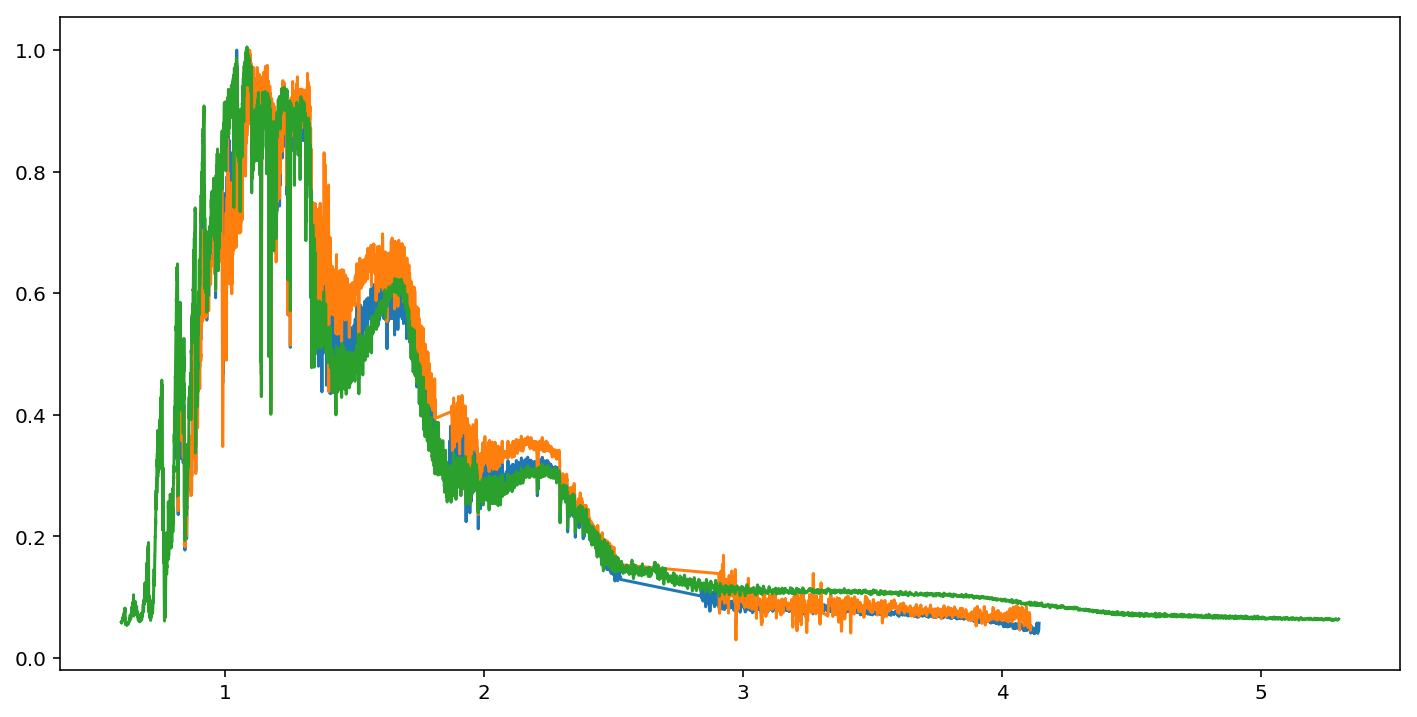

In [232]:
plt.figure(figsize=(12, 6))
plt.plot(irtf1.wavelength, irtf1.flux)
plt.plot(irtf2.wavelength, irtf2.flux)

f = flux_model(result[0], model)
plt.plot(model.wavelength, gaussian_filter1d(f, 80))

# 